# Lab 3: Adversarial Examples Lab

### Introduction

In this lab, we will explore the concept of adversarial examples as introduced in the seminal paper by Goodfellow et al. (2015): "Explaining and Harnessing Adversarial Examples." Adversarial examples are inputs to machine learning models that have been subtly modified to cause the model to make a mistake, while appearing nearly identical to the original input from a human perspective.

### Objectives

1. Understand why neural networks are vulnerable (podatny) to adversarial examples
2. Implement the Fast Gradient Sign Method (FGSM) to generate adversarial examples
3. Visualize how small, imperceptible (niedostrzegalny) perturbations can lead to high-confidence misclassifications

### Implementation

We'll train a simple deep learning model on the MNIST handwritten digit dataset, then apply FGSM to generate adversarial examples that fool our model.

### Setup Instructions

This notebook requires PyTorch and related libraries. If you encounter issues (napotkać problemy) installing these dependencies locally, you can run this notebook in Google Colab, which provides these libraries pre-installed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

In this section, we set up the data pipeline for our experiment:

1. **Device Configuration**: We determine whether to use GPU (CUDA) or CPU for computation.

2. **Data Transformation**: We apply a simple transformation to convert the MNIST images to PyTorch tensors. Unlike many image classification tasks, we don't normalize the pixel values here because MNIST pixel values are already in the range [0,1] after ToTensor()

3. **Dataset Loading**: We load the MNIST dataset, which consists of 28×28 grayscale images of handwritten digits (0-9).
   - Training set: 60,000 examples
   - Test set: 10,000 examples

4. **DataLoader Creation**: We create DataLoader objects that will feed batches (wprowadza porcje) of data to our model during training and evaluation.
   - We use a batch size of 64
   - We shuffle the training data to improve model generalization


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

batch_size = 64

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [3]:
torch.cuda.is_available()

False

In [6]:
print(torch.__version__)

2.6.0+cpu


### Display Data

Batch shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])


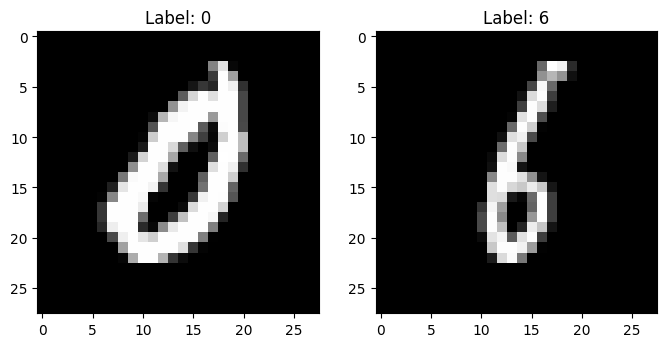

In [4]:
examples = iter(train_loader)
example_data, example_targets = next(examples)

print(f"Batch shape: {example_data.shape}")  # Should be [batch_size, channels, height, width]
print(f"Target shape: {example_targets.shape}")  # Should be [batch_size]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(example_data[0].squeeze(), cmap='gray')
axes[0].set_title(f'Label: {example_targets[0].item()}')
axes[1].imshow(example_data[1].squeeze(), cmap='gray')
axes[1].set_title(f'Label: {example_targets[1].item()}')
plt.show()

### Model Definition

Define a simple neural network for MNIST digit classification. 

Implement a neural network architecture of your choice. For simplicity, we recommend starting with a Multi-Layer Perceptron (MLP) with the following structure:
1. An input layer that flattens the 28x28 MNIST images
2. A hidden layer with 64 neurons and ReLU activation
3. An output layer with 10 neurons (one for each digit 0-9)

For implementation, use PyTorch's nn.Module as the base class and implement:
- The `__init__` method to define your network layers
- The `forward` method to define how data flows through your network

For model components, refer to:
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

<details>
  <summary>Hint 1</summary>
  Remember to flatten the input images in the forward method. MNIST images come in shape [batch_size, 1, 28, 28] and need to be reshaped to [batch_size, 784]. Use x = x.view(x.size(0), -1) for this purpose.
</details>

<details>
  <summary>Hint 2</summary>
  When creating your first linear layer, the input size should be 784 (28×28×1) to match the flattened MNIST images.
</details>

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = Net().to(device)
model_adam = Net().to(device)
model_adagrad = Net().to(device)

### Training the Neural Network

Below is a basic training loop for our MNIST classifier. We use CrossEntropyLoss as our loss function, which is the standard choice for multi-class classification problems. For optimization, we employ SGD (Stochastic Gradient Descent).

The training process consists of:
1. Forward pass through the network
2. Loss calculation
3. Gradient computation via backpropagation
4. Parameter updates using the optimizer

In [21]:
learning_rate = 1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)           # Step 1: Get predictions
        loss = criterion(outputs, labels) # Step 2: Measure error
        # Backward pass and optimize
        optimizer.zero_grad()             # Step 3: Clear old gradients
        loss.backward()                   # Step 4: Compute new gradients
        optimizer.step()                  # Step 5: Update model weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 1.3092
Epoch [2/10], Loss: 0.5062
Epoch [3/10], Loss: 0.3975
Epoch [4/10], Loss: 0.3560
Epoch [5/10], Loss: 0.3314
Epoch [6/10], Loss: 0.3140
Epoch [7/10], Loss: 0.2998
Epoch [8/10], Loss: 0.2878
Epoch [9/10], Loss: 0.2768
Epoch [10/10], Loss: 0.2672


### Model Evaluation
We evaluate our model's performance by measuring accuracy on the test dataset. This is a simplified approach - in a real environment, we would typically use a separate validation dataset and employ more comprehensive evaluation metrics. However, for the purposes of this notebook, this straightforward evaluation is sufficient to demonstrate the model's baseline performance before we explore adversarial examples.

We’re testing on ‘clean’ images (no tricks yet). A simple MLP should get ~90% accuracy — good, but not perfect.

In [22]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_acc = 100 * correct / total
print(f"Accuracy on clean test images: {clean_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 92.66% (expect ~90%)


### Comparing Optimizer Performance

For a challenge, try training with Adam, and Adagrad. Plot their losses. Which converges fastest?

Adam

In [23]:
learning_rate = 1e-2
loss_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_adam.parameters(), lr=learning_rate)

num_epochs = 10

model_adam.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_adam(images)           # Step 1: Get predictions
        loss = criterion(outputs, labels) # Step 2: Measure error
        # Backward pass and optimize
        optimizer.zero_grad()             # Step 3: Clear old gradients
        loss.backward()                   # Step 4: Compute new gradients
        optimizer.step()                  # Step 5: Update model weights

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.2434
Epoch [2/10], Loss: 0.1411
Epoch [3/10], Loss: 0.1186
Epoch [4/10], Loss: 0.1065
Epoch [5/10], Loss: 0.1005
Epoch [6/10], Loss: 0.0917
Epoch [7/10], Loss: 0.0848
Epoch [8/10], Loss: 0.0861
Epoch [9/10], Loss: 0.0810
Epoch [10/10], Loss: 0.0740


In [24]:
model_adam.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_acc = 100 * correct / total
print(f"Accuracy on clean test images: {clean_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 92.66% (expect ~90%)


Adagrad

In [25]:
learning_rate = 1e-2
loss_history_agrad = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model_adagrad.parameters(), lr=learning_rate)

num_epochs = 10

model_adagrad.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_adagrad(images)           # Step 1: Get predictions
        loss = criterion(outputs, labels) # Step 2: Measure error
        # Backward pass and optimize
        optimizer.zero_grad()             # Step 3: Clear old gradients
        loss.backward()                   # Step 4: Compute new gradients
        optimizer.step()                  # Step 5: Update model weights

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history_agrad.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.3579
Epoch [2/10], Loss: 0.2507
Epoch [3/10], Loss: 0.2236
Epoch [4/10], Loss: 0.2069
Epoch [5/10], Loss: 0.1948
Epoch [6/10], Loss: 0.1841
Epoch [7/10], Loss: 0.1757
Epoch [8/10], Loss: 0.1687
Epoch [9/10], Loss: 0.1625
Epoch [10/10], Loss: 0.1573


In [26]:
model_adagrad.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

clean_acc = 100 * correct / total
print(f"Accuracy on clean test images: {clean_acc:.2f}% (expect ~90%)")

Accuracy on clean test images: 92.66% (expect ~90%)


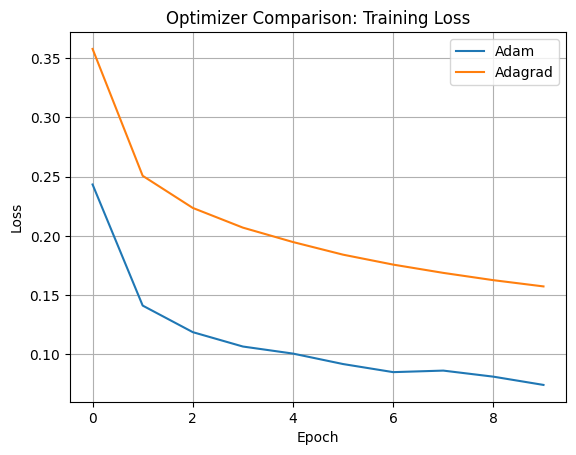

In [27]:
plt.plot(loss_history, label='Adam')
plt.plot(loss_history_agrad, label='Adagrad')
plt.title('Optimizer Comparison: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

If we choose a Adam optimizer, the looses function covergence fastest.

### FGSM Attack
Implement FGSM attack.

In [36]:
default_epsilon = 0.15

def fgsm_attack(
    model: nn.Module, images: torch.Tensor, labels: torch.Tensor, epsilon: float = default_epsilon
) -> torch.Tensor:
    """
    Creates adversarial examples via the FGSM method:
    x_adv = x + epsilon * sign( dJ/dx ).
    """
    images = images.clone().detach().to(device)
    labels = labels.to(device)

    # Ensure gradients are being tracked
    images.requires_grad = True

    # TODO: 
    # 1. Calculate outputs and loss
    # 2. Backpropagate loss (use backward method)
    # 3. Collect the element-wise sign of the data gradient (you can access it by images.grad.data.sign())
    # 4. Create the perturbed image
    # 5. Clamp to [0,1] if needed to ensure valid pixel range


    outputs = model(images)
        
    loss = criterion(outputs, labels)
        
    model.zero_grad()
        
    loss.backward()

    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()

    perturbed_image = images + epsilon * sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

### Calculate accuracy for adversarial examples

In [37]:
correct = 0
total = 0
for images, labels in test_loader:
    # Generate adversarial images
    adv_images = fgsm_attack(model, images, labels, default_epsilon)

    # Re-classify
    outputs = model(adv_images.to(device))
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum().item()

adv_acc = 100 * correct / total
print(f"Accuracy on adversarial test images (FGSM, eps={default_epsilon}): {adv_acc:.2f}%")

Accuracy on adversarial test images (FGSM, eps=0.15): 9.23%


### Display adversarial examples

Let's compare original and adversarial images side-by-side.

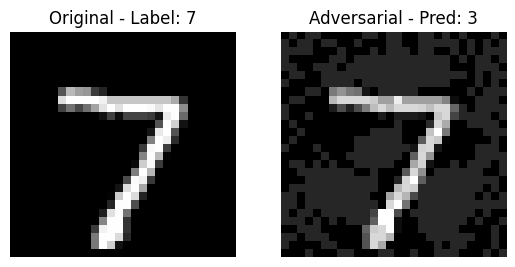

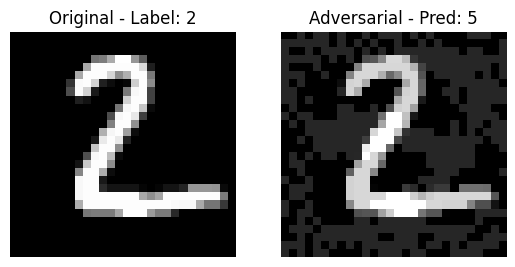

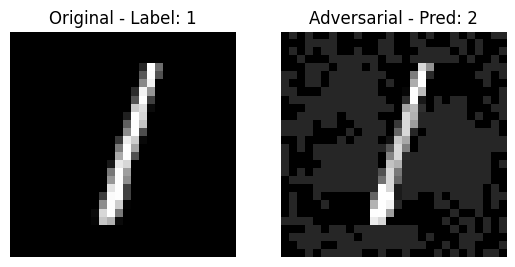

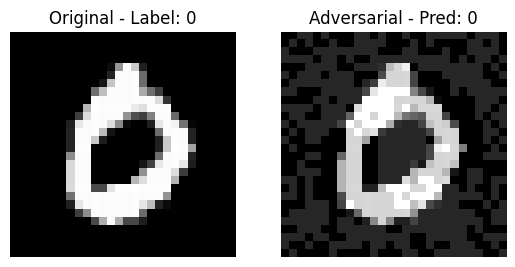

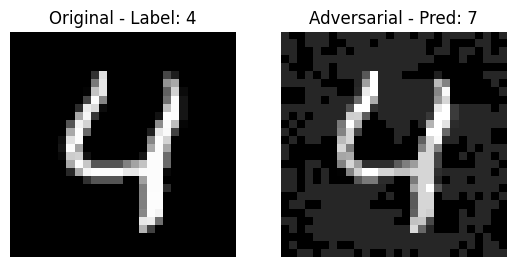

In [38]:
examples = iter(test_loader)
example_images, example_labels = next(examples)
example_images = example_images[:5]
example_labels = example_labels[:5]

adv_ex = fgsm_attack(model, example_images, example_labels, default_epsilon)

for i in range(5):
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title(f"Original - Label: {example_labels[i].item()}")
    plt.imshow(example_images[i][0].cpu(), cmap="gray")
    plt.axis("off")

    adv_label_out = model(adv_ex[i].unsqueeze(0))
    _, adv_pred = torch.max(adv_label_out, 1)
    plt.subplot(1, 2, 2)
    plt.title(f"Adversarial - Pred: {adv_pred.item()}")
    plt.imshow(adv_ex[i][0].detach().cpu(), cmap="gray")
    plt.axis("off")

    plt.show()

### Epsilon Parameter Analysis
 In this section, you'll analyze how the epsilon parameter affects the effectiveness of adversarial examples. The epsilon parameter controls the magnitude of the perturbation applied to the original images.

**Task:**
1. Evaluate the model's accuracy on adversarial examples generated with different epsilon values (try at least 5 different values)
2. Create a line plot showing model accuracy (y-axis) vs. epsilon value (x-axis)
3. Discuss the trade-off between:
- Visual perceptibility of the perturbations (higher epsilon = more visible changes)
- Attack success rate (higher epsilon = more successful attacks = lower model accuracy)

Epsilon: 0.02, Accuracy: 87.56%
Epsilon: 0.05, Accuracy: 74.41%
Epsilon: 0.10, Accuracy: 34.83%
Epsilon: 0.15, Accuracy: 9.23%
Epsilon: 0.20, Accuracy: 1.50%
Epsilon: 0.30, Accuracy: 0.01%


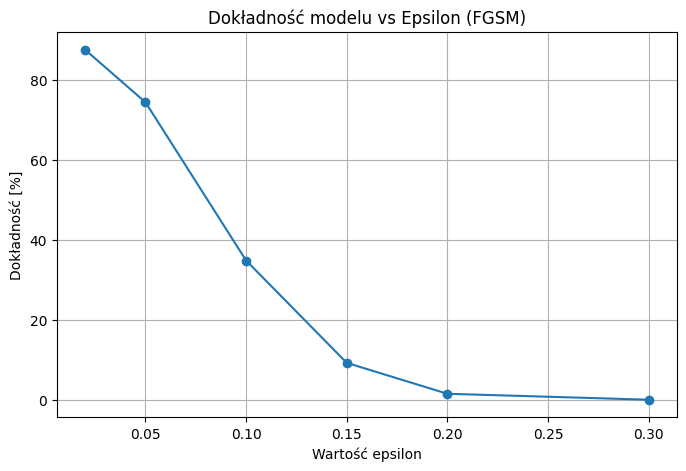

In [49]:
epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3]  
accuracies = []


for eps in epsilons:
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        adv_images = fgsm_attack(model, images, labels, eps)

  
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    accuracies.append(acc)
    print(f"Epsilon: {eps:.2f}, Accuracy: {acc:.2f}%")


plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o')
plt.title("Dokładność modelu vs Epsilon (FGSM)")
plt.xlabel("Wartość epsilon")
plt.ylabel("Dokładność [%]")
plt.grid(True)
plt.show()

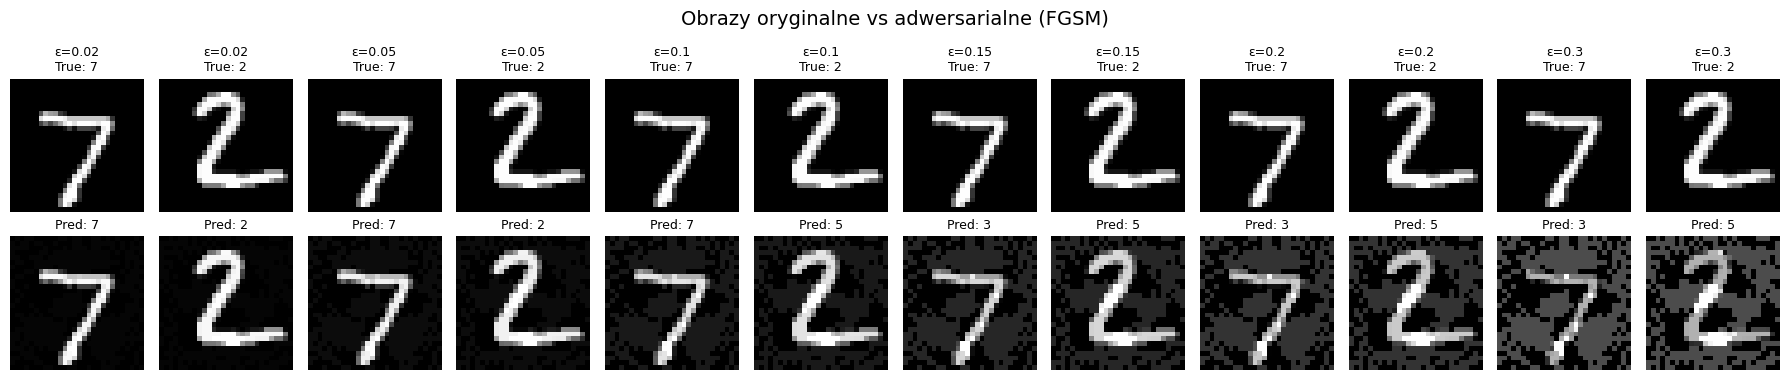

In [50]:
epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.3]
examples_per_epsilon = 2
model.eval()

fig, axs = plt.subplots(2, len(epsilons) * examples_per_epsilon, figsize=(3 * len(epsilons), 4))
fig.suptitle("Obrazy oryginalne vs adwersarialne (FGSM)", fontsize=14)

col_idx = 0

for eps in epsilons:
    shown = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images = fgsm_attack(model, images, labels, eps)
        outputs = model(adv_images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.shape[0]):
            if shown >= examples_per_epsilon:
                break

            orig = images[i].detach().cpu().squeeze()
            adv = adv_images[i].detach().cpu().squeeze()

            axs[0, col_idx].imshow(orig, cmap="gray")
            axs[0, col_idx].set_title(f"ε={eps}\nTrue: {labels[i].item()}", fontsize=9)
            axs[0, col_idx].axis('off')

            axs[1, col_idx].imshow(adv, cmap="gray")
            axs[1, col_idx].set_title(f"Pred: {preds[i].item()}", fontsize=9)
            axs[1, col_idx].axis('off')

            shown += 1
            col_idx += 1

        if shown >= examples_per_epsilon:
            break

plt.tight_layout()
plt.show()

### 1. Higher epsilon = more visible changes

- Epsilon defines how much perturbation we add to the image.  
- Small epsilons (e.g., `0.05`) cause minimal changes that are almost invisible to the human eye.  
- Large epsilons (e.g., `0.3`) produce noticeable distortions, which can even deform the image.


### 2. Higher epsilon = more successful attack = lower model accuracy

-Thanks to a higher epsilon, we can fool the model more effectively, but the attack becomes less subtle.
